In [77]:
import sqlite3
import pandas as pd
import numpy as np
ticker="MSFT"
# Connect to SQLite database
conn = sqlite3.connect('stock_data.db')

# Fetch data from database
cursor = conn.cursor()
cursor.execute(f"SELECT Symbol, CreatedAt,Sentiment, Body FROM tweets_MSFT WHERE Symbol='{ticker}' ") #AND RSI IS NOT NULL AND MA20 IS NOT NULL
#, MA5, MA10, MA20, RSI, UpperBB, MiddleBB, LowerBB, MACD, MACD_Signal 
data = cursor.fetchall()
conn.close()

In [78]:
df = pd.DataFrame(data=data, columns=["StockName","CreatedAt","Trend", "Body"])
# Conver to only date
df['CreatedAt'] = pd.to_datetime(df['CreatedAt']).dt.date

In [79]:
# Update Trend to Neutral where it is null
df.loc[df['Trend'].isnull(),'Trend']='Neutral'

In [80]:
df['Trend'].value_counts()

Trend
Neutral    46026
Bullish    20618
Bearish     9622
Name: count, dtype: int64

In [81]:
df["Sentiment_Score"] = df['Trend'].map({'Bearish' : -1, 'Bullish' : 1, 'Neutral' : 0})

In [82]:
df.head()

,StockName,CreatedAt,Trend,Body,Sentiment_Score
0,MSFT,2022-12-06,Neutral,$MSFT Bearish pattern based off 33 signals on ...,0
1,MSFT,2022-12-06,Bullish,$MSFT this is some kind of crazy crash and the...,1
2,MSFT,2022-12-06,Neutral,$MSFT https://www.stockilluminati.com/msft/new...,0
3,MSFT,2022-12-06,Neutral,Why Artificial Intelligence is only going to c...,0
4,MSFT,2022-12-06,Bullish,$AVCTQ Shout out To $MSFT WE WANT A BUY0UT???...,1


In [83]:
df_sentiment=df.groupby(['CreatedAt','Trend']).agg({'Sentiment_Score':'count'}).reset_index()

In [85]:
df_sentiment.Sentiment_Score.sum()

76266

In [88]:
df_pivot = pd.pivot_table(df_sentiment,index=['CreatedAt'], columns=['Trend'], values=['Sentiment_Score'], aggfunc='sum')

df_pivot.fillna(0, inplace=True)
type(df_pivot)

pandas.core.frame.DataFrame

In [91]:
df_pivot

Sentiment_Score                
Trend              Bearish Bullish Neutral
CreatedAt                                 
2022-12-06             0.0     2.0     4.0
2022-12-07             9.0    16.0    67.0
2022-12-08            13.0    42.0    58.0
2022-12-09             5.0    23.0    59.0
2022-12-10             1.0    10.0    31.0
...                    ...     ...     ...
2024-03-19            21.0    42.0    89.0
2024-03-20            15.0    52.0    54.0
2024-03-21            17.0    35.0    86.0
2024-03-22            14.0    22.0    52.0
2024-03-23             1.0     4.0     5.0

[474 rows x 3 columns]

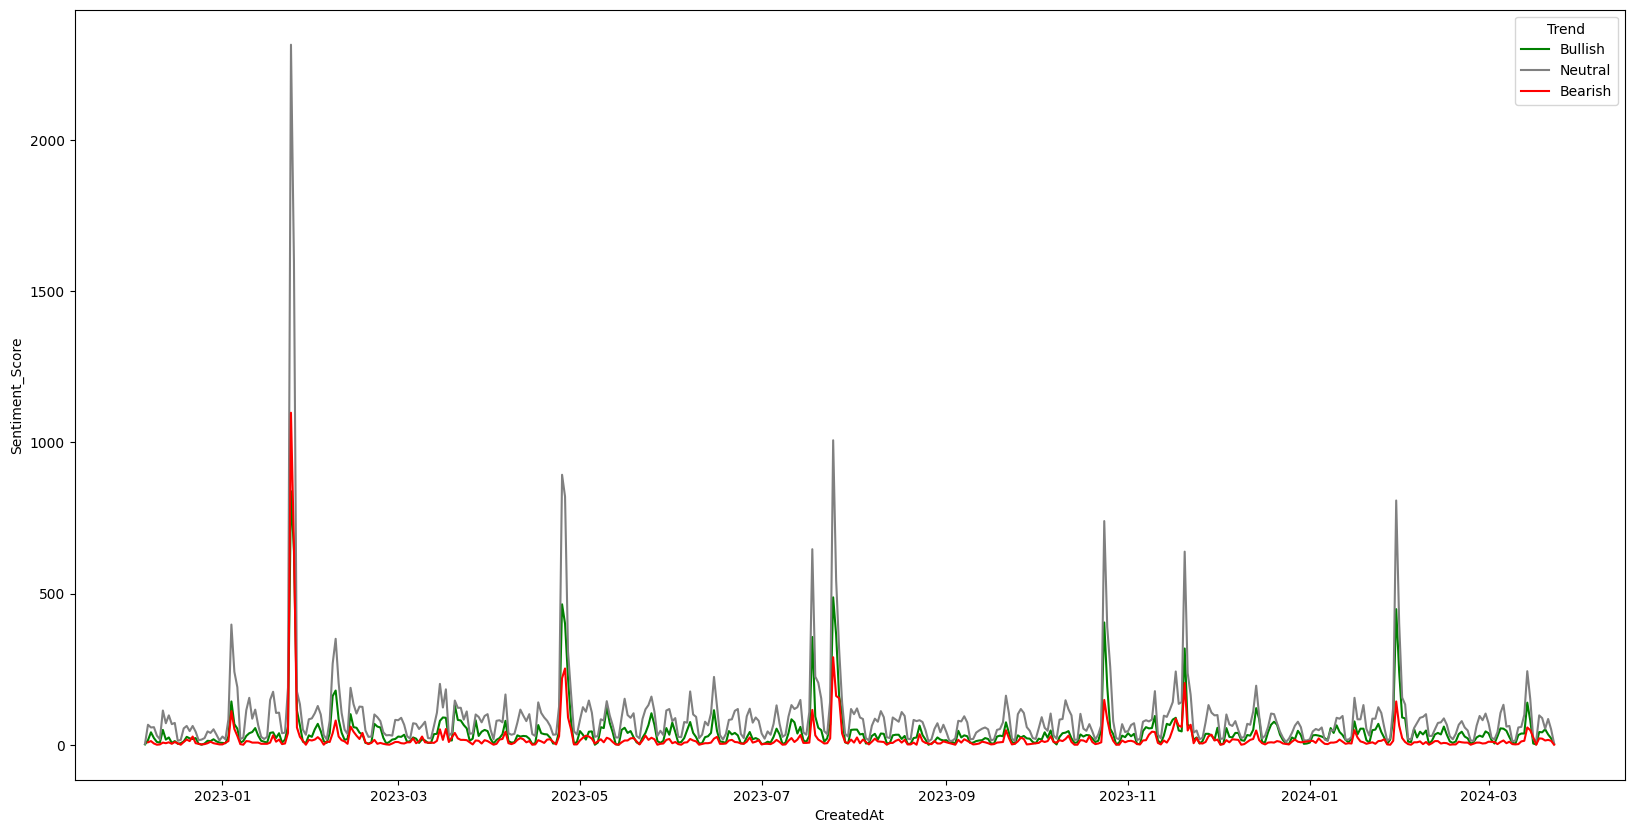

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
plt.figure(figsize=(20,10))
color_palette = {'Neutral' : 'gray', 'Bullish' : 'green', 'Bearish' : 'red'}
sns.lineplot(x = df_sentiment['CreatedAt'], y=df_sentiment['Sentiment_Score'].abs(), hue=df_sentiment['Trend'], palette=color_palette)
# go.scatter.Line(x=df_sentiment['CreatedAt'], y=df_sentiment['Sentiment_Score'].abs(), mode='lines')

# sns.lineplot(x = df_sentiment['CreatedAt'], y=df_sentiment['Sentiment_Score'].abs(), hue=df['Trend'])
# sns.lineplot(x = df_sentiment['CreatedAt'], y=df['Sentiment_Score'])
plt.show()

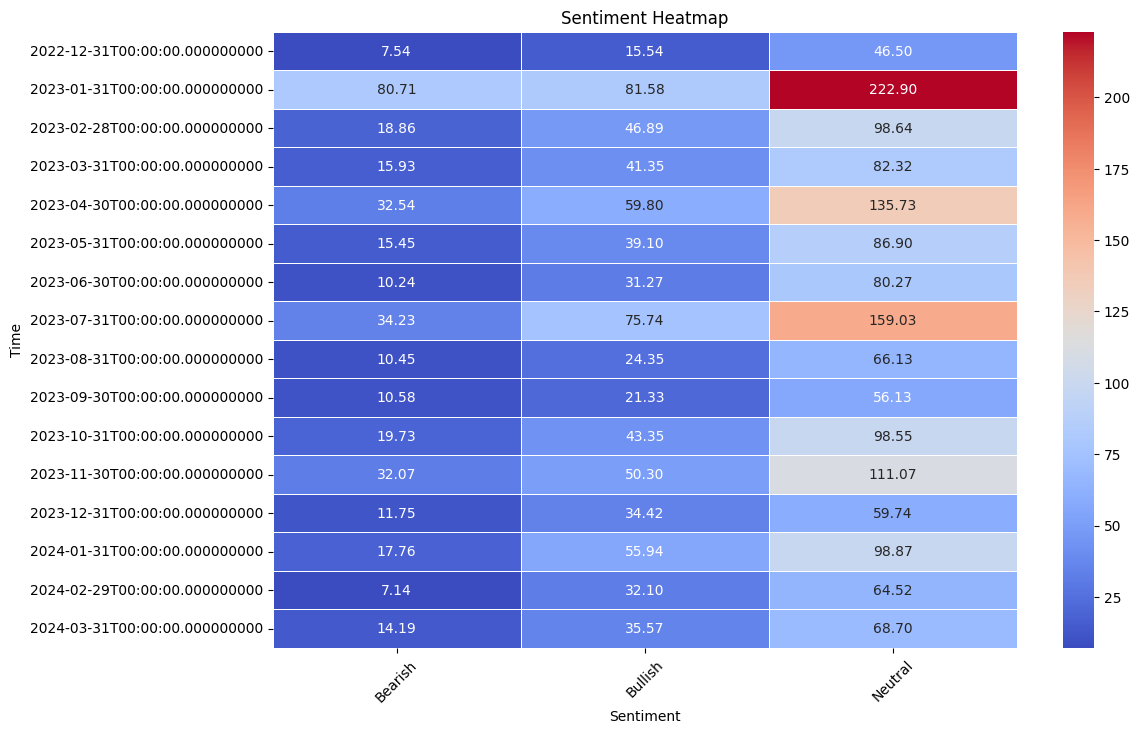

In [93]:
df_sentiment['CreatedAt'] = pd.to_datetime(df_sentiment['CreatedAt'])
sentiment_heatmap_data = df_sentiment.groupby([pd.Grouper(key='CreatedAt', freq='M'), 'Trend']).mean()['Sentiment_Score'].unstack()


# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Sentiment Heatmap')
plt.xlabel('Sentiment')
plt.ylabel('Time')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [94]:
df_sentiment

,CreatedAt,Trend,Sentiment_Score
0,2022-12-06,Bullish,2
1,2022-12-06,Neutral,4
2,2022-12-07,Bearish,9
3,2022-12-07,Bullish,16
4,2022-12-07,Neutral,67
...,...,...,...
1390,2024-03-22,Bullish,22
1391,2024-03-22,Neutral,52
1392,2024-03-23,Bearish,1
1393,2024-03-23,Bullish,4


In [95]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Load stopwords
stop_words = set(stopwords.words('english'))

# Step 1: Removing all Tickers in the comments
def remove_tickers(tweet):
    return re.sub(r'\$\w+', '', tweet)

# Step 2: Converting all characters into small letters
def convert_to_lowercase(tweet):
    return tweet.lower()

# Step 3: Removing all username mentions
def remove_user_mentions(tweet):
    return re.sub(r'@\w+', '', tweet)

# Step 4: Removing all numbers, emojis, and hyperlinks
def remove_numbers_emojis_hyperlinks(tweet):
    return re.sub(r'\d+|<[^>]+>|(http|https)://[^ ]+|[^a-zA-Z\s]', '', tweet)

# Step 5: Removing all commonly used words (Stopwords)
def remove_stopwords(tweet):
    return ' '.join([word for word in tweet.split() if word not in stop_words])

# Applying preprocessing steps
df['processed_tweet'] = df['Body'].apply(remove_tickers)
df['processed_tweet'] = df['processed_tweet'].apply(convert_to_lowercase)
df['processed_tweet'] = df['processed_tweet'].apply(remove_user_mentions)
df['processed_tweet'] = df['processed_tweet'].apply(remove_numbers_emojis_hyperlinks)
df['processed_tweet'] = df['processed_tweet'].apply(remove_stopwords)

# # Step 6: Vectorization
# tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed
# X = tfidf_vectorizer.fit_transform(df_sentiment['processed_tweet'])


In [96]:
len(df['Sentiment_Score'].isnull()), len(df), df.head()

(76266,
 76266,
   StockName   CreatedAt    Trend  \
 0      MSFT  2022-12-06  Neutral   
 1      MSFT  2022-12-06  Bullish   
 2      MSFT  2022-12-06  Neutral   
 3      MSFT  2022-12-06  Neutral   
 4      MSFT  2022-12-06  Bullish   
 
                                                 Body  Sentiment_Score  \
 0  $MSFT Bearish pattern based off 33 signals on ...                0   
 1  $MSFT this is some kind of crazy crash and the...                1   
 2  $MSFT https://www.stockilluminati.com/msft/new...                0   
 3  Why Artificial Intelligence is only going to c...                0   
 4  $AVCTQ Shout out To $MSFT  WE WANT A BUY0UT???...                1   
 
                                processed_tweet  
 0      bearish pattern based signals min chart  
 1               kind crazy crash theres reason  
 2     dividend growth stock watchlist december  
 3  artificial intelligence going continue grow  
 4                             shout want buyut  )

In [25]:
unlabeled_data = df[df['Trend']=='Neutral']
unlabeled_data

,StockName,CreatedAt,Trend,Body,Sentiment_Score,processed_tweet
0,MSFT,2022-12-06,Neutral,$MSFT Bearish pattern based off 33 signals on ...,0,bearish pattern based signals min chart
2,MSFT,2022-12-06,Neutral,$MSFT https://www.stockilluminati.com/msft/new...,0,dividend growth stock watchlist december
3,MSFT,2022-12-06,Neutral,Why Artificial Intelligence is only going to c...,0,artificial intelligence going continue grow
5,MSFT,2022-12-06,Neutral,Which stock is the best to invest? Compare $MS...,0,stock best invest compare vs microsoft
6,MSFT,2022-12-07,Neutral,Sweep Options Activity: $MSFT is the #25 ticke...,0,sweep options activity ticker sweep activity i...
...,...,...,...,...,...,...
76257,MSFT,2024-03-23,Neutral,$NVDA CATHIE de $tsla $arkk full interview ...,0,cathie de full interview thesis bigger
76258,MSFT,2024-03-23,Neutral,$MSFT Doing covered calls since past 5 months ...,0,covered calls since past months let buy mores ...
76260,MSFT,2024-03-23,Neutral,$ARMCO only story on the planet about $m...,0,story planet losing deals
76261,MSFT,2024-03-23,Neutral,$MSFT $NVDA $PLTR $QQQ loading PALANTIR!!!,0,loading palantir


In [26]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ratis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [97]:
# Create a SentimentIntensityAnalyzer object.
sia = SentimentIntensityAnalyzer()
# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 

 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sia.polarity_scores(sentence)
     
    print("Overall sentiment dictionary is : ", sentiment_dict)
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
 
    print("Sentence Overall Rated As", end = " ")
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positive")
 
    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negative")
 
    else :
        print("Neutral")

In [98]:
# sia = SentimentIntensityAnalyzer()
# df['score'] = df['tweet'].apply(lambda x: sia.polarity_scores(x)['compound'])
# print('APPL misses earnings, analyst suggest downgrade , sell now ')
sentiment_scores('Apple misses earnings, analyst suggest downgrade , sell now ')

Overall sentiment dictionary is :  {'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.2263}
sentence was rated as  21.3 % Negative
sentence was rated as  78.7 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Negative


In [99]:
positive_words='buy bull long support undervalued underpriced cheap upward rising trend moon rocket hold breakout call beat support buying holding high profit'
negative_words='sell bear bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss resistance squeeze cover seller downgrade'


dictOfpos = { i : 4 for i in positive_words.split(" ") }
dictOfneg = { i : -4 for i in negative_words.split(" ")  }
Financial_Lexicon = {**dictOfpos, **dictOfneg}

sia.lexicon.update(Financial_Lexicon)


print('Apple misses earnings, analyst suggest downgrade , sell now ')
sentiment_scores('tesla misses earnings, analyst suggest downgrade , sell now ')

Apple misses earnings, analyst suggest downgrade , sell now 
Overall sentiment dictionary is :  {'neg': 0.704, 'neu': 0.296, 'pos': 0.0, 'compound': -0.9169}
sentence was rated as  70.39999999999999 % Negative
sentence was rated as  29.599999999999998 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Negative


In [61]:
df  

,StockName,CreatedAt,Trend,Body,Sentiment_Score,processed_tweet,score,vader_Sentiment
0,MSFT,2022-12-06,Neutral,$MSFT Bearish pattern based off 33 signals on ...,0,bearish pattern based signals min chart,-0.7184,Negative
1,MSFT,2022-12-06,Bullish,$MSFT this is some kind of crazy crash and the...,1,kind crazy crash theres reason,-0.1779,Negative
2,MSFT,2022-12-06,Neutral,$MSFT https://www.stockilluminati.com/msft/new...,0,dividend growth stock watchlist december,0.3818,Positive
3,MSFT,2022-12-06,Neutral,Why Artificial Intelligence is only going to c...,0,artificial intelligence going continue grow,0.4767,Positive
4,MSFT,2022-12-06,Bullish,$AVCTQ Shout out To $MSFT WE WANT A BUY0UT???...,1,shout want buyut,0.0772,Positive
...,...,...,...,...,...,...,...,...
76261,MSFT,2024-03-23,Neutral,$MSFT $NVDA $PLTR $QQQ loading PALANTIR!!!,0,loading palantir,0.0000,Neutral
76262,MSFT,2024-03-23,Neutral,$PLTR $NVDA $MSFT $QQQ,0,,0.0000,Neutral
76263,MSFT,2024-03-23,Bullish,$SPY $QQQ $MSFT imagine the wealth \n\nhttps:/...,1,imagine wealth,0.4939,Positive
76264,MSFT,2024-03-23,Bullish,[Unveiling Market Leaders who are outpacing th...,1,unveiling market leaders outpacing competition...,0.9781,Positive


In [100]:
df['score'] = df['processed_tweet'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [102]:
df['vader_Sentiment'] = df['score'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))

In [103]:
df

,StockName,CreatedAt,Trend,Body,Sentiment_Score,processed_tweet,score,vader_Sentiment
0,MSFT,2022-12-06,Neutral,$MSFT Bearish pattern based off 33 signals on ...,0,bearish pattern based signals min chart,-0.7184,Negative
1,MSFT,2022-12-06,Bullish,$MSFT this is some kind of crazy crash and the...,1,kind crazy crash theres reason,-0.1779,Negative
2,MSFT,2022-12-06,Neutral,$MSFT https://www.stockilluminati.com/msft/new...,0,dividend growth stock watchlist december,0.3818,Positive
3,MSFT,2022-12-06,Neutral,Why Artificial Intelligence is only going to c...,0,artificial intelligence going continue grow,0.4767,Positive
4,MSFT,2022-12-06,Bullish,$AVCTQ Shout out To $MSFT WE WANT A BUY0UT???...,1,shout want buyut,0.0772,Positive
...,...,...,...,...,...,...,...,...
76261,MSFT,2024-03-23,Neutral,$MSFT $NVDA $PLTR $QQQ loading PALANTIR!!!,0,loading palantir,0.0000,Neutral
76262,MSFT,2024-03-23,Neutral,$PLTR $NVDA $MSFT $QQQ,0,,0.0000,Neutral
76263,MSFT,2024-03-23,Bullish,$SPY $QQQ $MSFT imagine the wealth \n\nhttps:/...,1,imagine wealth,0.4939,Positive
76264,MSFT,2024-03-23,Bullish,[Unveiling Market Leaders who are outpacing th...,1,unveiling market leaders outpacing competition...,0.9781,Positive


In [104]:
df["Sentiment_Score"] = df['vader_Sentiment'].map({'Positive' : -1, 'Negative' : 1, 'Neutral' : 0})

In [105]:
df.Sentiment_Score.value_counts()

Sentiment_Score
 0    30455
-1    30001
 1    15810
Name: count, dtype: int64

In [106]:
df_sa_pivot = pd.pivot_table(df,index='CreatedAt', columns='Trend', values='Sentiment_Score', aggfunc='count')
df_sa_pivot.fillna(0, inplace=True)
df_sa_pivot1=df_sa_pivot.reset_index()

In [107]:
df_sa_pivot1

Trend,CreatedAt,Bearish,Bullish,Neutral
0,2022-12-06,0.0,2.0,4.0
1,2022-12-07,9.0,16.0,67.0
2,2022-12-08,13.0,42.0,58.0
3,2022-12-09,5.0,23.0,59.0
4,2022-12-10,1.0,10.0,31.0
...,...,...,...,...
469,2024-03-19,21.0,42.0,89.0
470,2024-03-20,15.0,52.0,54.0
471,2024-03-21,17.0,35.0,86.0
472,2024-03-22,14.0,22.0,52.0


In [108]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly

fig = plotly.subplots.make_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.05)
# Add the second trace (Sentiment) with the right y-axis to the first subplot
fig.add_trace(go.Scatter(x=df_sa_pivot1['CreatedAt'], y=df_sa_pivot1['Bearish'] , mode='lines', name='Bearish', yaxis='y1'), row=1, col=1)

fig.add_trace(go.Scatter(x=df_sa_pivot1['CreatedAt'], y=df_sa_pivot1['Bullish'], mode='lines', name='Bullish', yaxis='y1'), row=2, col=1)

fig.add_trace(go.Scatter(x=df_sa_pivot1['CreatedAt'], y=df_sa_pivot1['Neutral'], mode='lines', name='Neutral', yaxis='y1'), row=3, col=1)


# Update layout
fig.update_layout(title_text='Close Price vs Sentiment Over Time', xaxis_title='Date')

# # Update y-axis titles
fig.update_yaxes(title_text="Bearish", row=1, col=1)
fig.update_yaxes(title_text="Bullish", row=2, col=1)
fig.update_yaxes(title_text="Neutral", row=3, col=1)
# fig.update_yaxes(title_text="Close Price", row=4, col=1)

fig.show()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

labeled_data = df[df['Trend']!='Neutral'][["Body","Sentiment_Score"]]
unlabeled_data = df[df['Trend']=='Neutral'][["Body","Sentiment_Score"]]
print(labeled_data.shape, unlabeled_data.shape)
# Assume 'labeled_data' contains a small amount of labeled data with 'text' and 'sentiment' columns
# Assume 'unlabeled_data' contains a large amount of unlabeled data with only 'text' column

# Split labeled data into training and validation sets
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(
    labeled_data['Body'], labeled_data['Sentiment_Score'], test_size=0.2, random_state=42)

# Extract features from labeled and unlabeled data using TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_labeled_train_tfidf = tfidf_vectorizer.fit_transform(X_labeled_train)
X_labeled_val_tfidf = tfidf_vectorizer.transform(X_labeled_val)
X_unlabeled_tfidf = tfidf_vectorizer.transform(unlabeled_data['Body'])

# Initialize a sentiment classifier (e.g., SVM)
classifier = SVC(kernel='linear')

# Train the classifier on the labeled data
classifier.fit(X_labeled_train_tfidf, y_labeled_train)

# Evaluate the classifier on the validation set
y_pred_val = classifier.predict(X_labeled_val_tfidf)
accuracy = accuracy_score(y_labeled_val, y_pred_val)
print("Accuracy on validation set (labeled data only):", accuracy)

# Semi-supervised learning loop
while True:
    # Use the classifier to predict sentiments for the unlabeled data
    pseudo_labels = classifier.predict(X_unlabeled_tfidf)
    
    # Combine labeled data with pseudo-labeled data
    X_combined = np.vstack([X_labeled_train_tfidf.toarray(), X_unlabeled_tfidf.toarray()])
    y_combined = np.concatenate([y_labeled_train, pseudo_labels])
    
    # Retrain the classifier on the combined data
    classifier.fit(X_combined, y_combined)
    
    # Use the classifier to predict sentiments for the validation set
    y_pred_val = classifier.predict(X_labeled_val_tfidf)
    new_accuracy = accuracy_score(y_labeled_val, y_pred_val)
    print("Accuracy on validation set (semi-supervised learning):", new_accuracy)
    # Check for convergence
    if new_accuracy == accuracy:
        break
    else:
        accuracy = new_accuracy

# Final evaluation on the validation set
print("Final accuracy on validation set (semi-supervised learning):", accuracy)


(30240, 2) (46026, 2)
Accuracy on validation set (labeled data only): 0.7761243386243386


ValueError: cannot use sparse input in 'SVC' trained on dense data